In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np 
from matplotlib import pyplot as plt 
import networkx as nx 
import pandas as pd 

In [3]:
from dotenv import load_dotenv
import os, sys

load_dotenv()

# Load PROJECT_ROOT
PROJECT_ROOT = os.getenv("PROJECT_ROOT")

# Add PROJECT_ROOT to sys.path
sys.path.append(PROJECT_ROOT)

In [4]:
routes_df = pd.read_csv(os.path.join(PROJECT_ROOT, "output", "cs_2023-04-01.routes.csv"))
# Column names: flight_id	real_waypoints	pass_times	speeds	real_full_waypoints	full_pass_times	full_speeds
routes_df.head()

,flight_id,real_waypoints,pass_times,speeds,real_full_waypoints,full_pass_times,full_speeds
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300.423041 1680364679.0 1680382679.0 16...,0.232055441288291 0.1399177216897295 0.0 0.0,INKIM LJLJ LMML MALTI,1680349300.423041 1680364679.0 1680382679.0 16...,0.232055441288291 0.1399177216897295 0.0 0.0
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362647.7111955 1680362759.0 1680364319.0,0.2708200616447602 0.2365236792294908 0.0,LAKTO _gF5iC5xl BIRES_29 _WVEbJaev _g1hCzus1 _...,1680362647.7111955 1680362639.0 1680362759.0 1...,0.2708200616447602 0.2708200616447602 0.236523...
2,010092MSR742,LCA SOBOS_91 SISIM,1680368181.733776 1680368399.0 1680369839.0,0.1243140953887899 0.1647557215374644 0.0,LCA _ByVDvezp _U5fOtBwe SOBOS_91 _95Zzzy8a _JI...,1680368181.733776 1680368219.0 1680368279.0 16...,0.1243140953887899 0.1243140953887899 0.133769...
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357.2509093 1680335219.0 1680335279.0 1...,0.2004357713888871 0.2004357713888871 0.219747...,TANSA_98 METRU METRU_30 TOTTI LOTIN _IbQeAa65 ...,1680335357.2509093 1680335219.0 1680335279.0 1...,0.2004357713888871 0.2004357713888871 0.219747...
4,010092MSR832,ODGAX LUMED METRU_30,1680346618.9892123 1680347039.0 1680350699.0,0.2367439844382014 0.2639328416883039 0.0,ODGAX _ElzZMoHl _Ksq0NRk4 LUMED _13qyeNz9 _4Pz...,1680346618.9892123 1680346619.0 1680346679.0 1...,0.2367439844382014 0.2367439844382014 0.240870...


In [5]:
# Load the waypoints graph (nodes only)
ats_fra_graph = nx.read_gml(os.path.join(PROJECT_ROOT, "data", "graphs", "ats_fra_nodes_only.gml"))
print(f"ATS-FRA graph has {ats_fra_graph.number_of_nodes()} nodes and {ats_fra_graph.number_of_edges()} edges")

ATS-FRA graph has 33763 nodes and 0 edges


In [6]:
from utils.haversine import haversine_distance

# Function to extract first and last waypoints from the route
def get_first_last_waypoints(waypoints_str):
    waypoints = waypoints_str.split()
    if len(waypoints) < 2:
        return None, None
    return waypoints[0], waypoints[-1]

# Calculate the great circle distance for each route
def calculate_gc_distance(row):
    first_wp, last_wp = get_first_last_waypoints(row['real_waypoints'])
    
    if first_wp is None or last_wp is None:
        return np.nan
    
    try:
        # Get coordinates from the graph
        first_node = ats_fra_graph.nodes[first_wp]
        last_node = ats_fra_graph.nodes[last_wp]
        
        # Calculate distance
        distance = haversine_distance(
            first_node['lat'], first_node['lon'],
            last_node['lat'], last_node['lon']
        )
        return distance
    except KeyError:
        # Handle case where waypoint is not in the graph
        return np.nan

# Add the route_gc_length column to the dataframe
routes_df['route_gc_length'] = routes_df.apply(calculate_gc_distance, axis=1)

# Display the first few rows with the new column
routes_df.head()


,flight_id,real_waypoints,pass_times,speeds,real_full_waypoints,full_pass_times,full_speeds,route_gc_length
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300.423041 1680364679.0 1680382679.0 16...,0.232055441288291 0.1399177216897295 0.0 0.0,INKIM LJLJ LMML MALTI,1680349300.423041 1680364679.0 1680382679.0 16...,0.232055441288291 0.1399177216897295 0.0 0.0,439.718803
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362647.7111955 1680362759.0 1680364319.0,0.2708200616447602 0.2365236792294908 0.0,LAKTO _gF5iC5xl BIRES_29 _WVEbJaev _g1hCzus1 _...,1680362647.7111955 1680362639.0 1680362759.0 1...,0.2708200616447602 0.2708200616447602 0.236523...,155.366418
2,010092MSR742,LCA SOBOS_91 SISIM,1680368181.733776 1680368399.0 1680369839.0,0.1243140953887899 0.1647557215374644 0.0,LCA _ByVDvezp _U5fOtBwe SOBOS_91 _95Zzzy8a _JI...,1680368181.733776 1680368219.0 1680368279.0 16...,0.1243140953887899 0.1243140953887899 0.133769...,180.431463
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357.2509093 1680335219.0 1680335279.0 1...,0.2004357713888871 0.2004357713888871 0.219747...,TANSA_98 METRU METRU_30 TOTTI LOTIN _IbQeAa65 ...,1680335357.2509093 1680335219.0 1680335279.0 1...,0.2004357713888871 0.2004357713888871 0.219747...,610.653254
4,010092MSR832,ODGAX LUMED METRU_30,1680346618.9892123 1680347039.0 1680350699.0,0.2367439844382014 0.2639328416883039 0.0,ODGAX _ElzZMoHl _Ksq0NRk4 LUMED _13qyeNz9 _4Pz...,1680346618.9892123 1680346619.0 1680346679.0 1...,0.2367439844382014 0.2367439844382014 0.240870...,559.241133


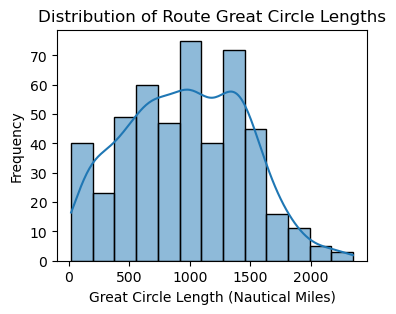

In [7]:
# Create a histogram of route great circle lengths using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.histplot(data=routes_df, x='route_gc_length', kde=True)
plt.title('Distribution of Route Great Circle Lengths')
plt.xlabel('Great Circle Length (Nautical Miles)')
plt.ylabel('Frequency')
plt.show()


# OD pairs

In [8]:
# From routes_df, add two columns: first_wp and last_wp
routes_df['first_wp'] = routes_df['real_waypoints'].str.split().str[0]
routes_df['last_wp'] = routes_df['real_waypoints'].str.split().str[-1]
# Add latitude and longitude columns for first and last waypoints
def get_waypoint_coordinates(row, wp_type):
    """
    Get the latitude and longitude of a waypoint from the graph.
    
    Args:
        row: DataFrame row
        wp_type: 'first_wp' or 'last_wp'
    
    Returns:
        tuple: (latitude, longitude) or (np.nan, np.nan) if waypoint not found
    """
    waypoint = row[wp_type]
    try:
        node = ats_fra_graph.nodes[waypoint]
        return node['lat'], node['lon']
    except KeyError:
        return np.nan, np.nan

# Get coordinates for first waypoint
routes_df['first_wp_lat'], routes_df['first_wp_lon'] = zip(*routes_df.apply(
    lambda row: get_waypoint_coordinates(row, 'first_wp'), axis=1
))

# Get coordinates for last waypoint
routes_df['last_wp_lat'], routes_df['last_wp_lon'] = zip(*routes_df.apply(
    lambda row: get_waypoint_coordinates(row, 'last_wp'), axis=1
))

routes_df.head()

,flight_id,real_waypoints,pass_times,speeds,real_full_waypoints,full_pass_times,full_speeds,route_gc_length,first_wp,last_wp,first_wp_lat,first_wp_lon,last_wp_lat,last_wp_lon
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300.423041 1680364679.0 1680382679.0 16...,0.232055441288291 0.1399177216897295 0.0 0.0,INKIM LJLJ LMML MALTI,1680349300.423041 1680364679.0 1680382679.0 16...,0.232055441288291 0.1399177216897295 0.0 0.0,439.718803,INKIM,MALTI,42.835833,14.165278,35.512700,14.283900
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362647.7111955 1680362759.0 1680364319.0,0.2708200616447602 0.2365236792294908 0.0,LAKTO _gF5iC5xl BIRES_29 _WVEbJaev _g1hCzus1 _...,1680362647.7111955 1680362639.0 1680362759.0 1...,0.2708200616447602 0.2708200616447602 0.236523...,155.366418,LAKTO,LCLK,32.633333,32.083333,34.878889,33.630278
2,010092MSR742,LCA SOBOS_91 SISIM,1680368181.733776 1680368399.0 1680369839.0,0.1243140953887899 0.1647557215374644 0.0,LCA _ByVDvezp _U5fOtBwe SOBOS_91 _95Zzzy8a _JI...,1680368181.733776 1680368219.0 1680368279.0 16...,0.1243140953887899 0.1243140953887899 0.133769...,180.431463,LCA,SISIM,34.872861,33.625581,32.134444,32.140833
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357.2509093 1680335219.0 1680335279.0 1...,0.2004357713888871 0.2004357713888871 0.219747...,TANSA_98 METRU METRU_30 TOTTI LOTIN _IbQeAa65 ...,1680335357.2509093 1680335219.0 1680335279.0 1...,0.2004357713888871 0.2004357713888871 0.219747...,610.653254,TANSA_98,REXUN,34.000000,26.490000,33.535000,14.260833
4,010092MSR832,ODGAX LUMED METRU_30,1680346618.9892123 1680347039.0 1680350699.0,0.2367439844382014 0.2639328416883039 0.0,ODGAX _ElzZMoHl _Ksq0NRk4 LUMED _13qyeNz9 _4Pz...,1680346618.9892123 1680346619.0 1680346679.0 1...,0.2367439844382014 0.2367439844382014 0.240870...,559.241133,ODGAX,METRU_30,33.631667,13.882222,34.000000,25.090000
